In [34]:
import numpy as np
import scipy.stats as stats
import time
import yaml
import matplotlib.pyplot as plt
import matplotlib as mpl


plt.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.linewidth'] = 2 
plt.rcParams.update({"text.usetex": True})
mpl.rc('xtick', labelsize=12) 
mpl.rc('ytick', labelsize=12) 


In [2]:
from numba import jit, prange

In [6]:
pars = np.empty(shape = 5, dtype = object)

In [7]:
T, N_t = 1., 100

In [29]:
pars[0] = np.array([.08, -.08, .5])
pars[1] = np.array([62., 40.])
pars[2] = np.array([1000., -.044, .007])
pars[3] = T
pars[4] = N_t

In [12]:
@jit(nopython = True)
def rng(n = 1):
    return np.random.randn(n)

In [23]:
@jit(nopython = True)
def two_fPDV(betas, lambdas, x_0, T, N_t):
    
    sigma = lambda r_1, r_2: betas[0] + betas[1] * r_1 + betas[2] * np.sqrt(r_2)
    x = np.zeros((3, N_t))
    x[:, 0] = x_0
    dt = T / N_t

    mu = np.zeros(3)
    delta = np.zeros((3, 3))
    
    for n in range(1, N_t):
        
        mu[1] = -lambdas[0] * x[1, n - 1]
        mu[2] = lambdas[1] * (sigma(x[1, n - 1], x[2, n - 1])**2 - x[2, n - 1])

        delta[0, 0] = x[0, n - 1] * sigma(x[1, n - 1], x[2, n - 1])
        delta[1, 1] = lambdas[0] * sigma(x[1, n - 1], x[2, n - 1])
        z = rng()[0]
        w = np.sqrt(dt) * np.array([z] * 3)

        x[:, n] = x[:, n - 1] + mu * dt + delta@w
    
    return x    

In [30]:
betas, lambdas, x_0, T, N_t = pars

In [28]:
x_0

array([-0.044,  0.007])

In [31]:
x = two_fPDV(betas, lambdas, x_0, T, N_t)

In [33]:
t_grid = np.linspace(0., T, N_t)

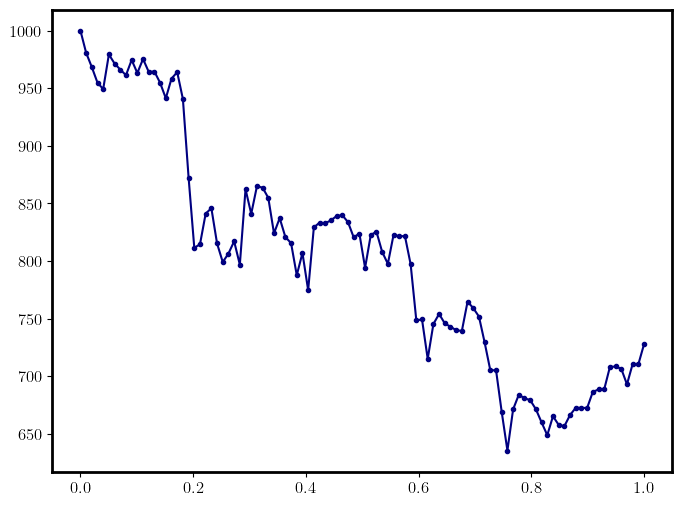

In [35]:
plt.plot(t_grid, x[0, :], '.-', color = 'navy')

In [49]:
@jit(parallel = True)
def price_mc(n_samples, strikes, betas, lambdas, x_0, T, N_t):
    prices = np.zeros_like(strikes)

    for k in prange(strikes.shape[0]):
        x = np.zeros(n_samples)
        for n in prange(n_samples):
            x[n] = two_fPDV(betas, lambdas, x_0, T, N_t)[0, -1]
        
        prices[k] = np.maximum(x - strikes[k], 0.).mean()

    return prices

In [75]:
strikes = np.arange(800., 2500., 50)
n_samples = 10_000

In [71]:
prices = price_mc(n_samples, strikes, betas, lambdas, x_0, T, N_t)

In [45]:
from scipy import stats
N = stats.norm.cdf
n = stats.norm.pdf

def PriceBS(S, t, K, r, T, sig, flag='C'):

    d_1  = (np.log(S/K) + (r+(sig**2/2))*np.sqrt(T-t))  / (sig * np.sqrt(T-t))
    d_2 = d_1 - sig * np.sqrt(T-t)
    C = S * N(d_1) - K * np.exp(-r*(T-t)) * N(d_2)
    if flag =='C':
        return C
    if flag=='P':
        return  C - S + K * np.exp(-r*(T-t))
    if flag not in ['C', 'P']:
        raise ValueError('Enter C or P')  


# Greeks :

class Greeks:
    
    def __init__(self, S, t, K, r, T, sig):
        self.S = S
        self.t = t
        self.K = K
        self.r = r
        self.T = T
        self.sig = sig
        return None

    def __d_1(self):
        
        d_1  = (np.log(self.S / self.K) + (self.r+(self.sig**2/2))*np.sqrt(self.T-self.t))  / (self.sig * np.sqrt(self.T-self.t))
        return d_1
    def __d_2(self):
        
        d_2 = Greeks.__d_1(self) - self.sig * np.sqrt(self.T-self.t)
        return d_2
    

    def Delta(self):
        
        return N(Greeks.__d_1(self))

    def Gamma(self):
        
        return n(Greeks.__d_1(self)) / (self.S * self.sig * np.sqrt(self.T-self.t))

    def Theta(self):
        
        return (self.S * self.sig * n(Greeks.__d_1(self)))/ (2 * np.sqrt(self.T - self.t)) + self.r * self.K * np.exp(-self.r * (self.T - self.t)) * N(Greeks.__d_2(self))

    def Vega(self):
        
        return self.S * np.sqrt(self.T - self.t) *    n(Greeks.__d_1(self))
    
    def Rho(self):
        
        return self.K * (self.T - self.t) *  np.exp(-self.r * (self.T - self.t)) * N(Greeks.__d_2(self))

    def dCdK(self):
        
        return - np.exp(-self.r * (self.T - self.t)) * N(Greeks.__d_2(self))    


def implidVolatility(S, t, K, r, T, sig_0, 
                     C_market, maxIter = 50, 
                     tolerance = 1e-5, 
                     method = 'N-R', 
                     flag = 'C', 
                     a = .0001, b = 2.0):
    
    if method == 'N-R':

        sig = sig_0
        C = PriceBS(S, t, K, r, T, sig, flag)

        stopping_criterion = np.abs(C - C_market)
        iter = 0

        while((stopping_criterion > tolerance) & (iter < maxIter)):
            iter += 1
            Vega = Greeks(S, t, K, r, T, sig).Vega()
            
            if Vega == float(0):
                message = 'Vega equals ', 0 , 'at iteration :', iter, '. I Suggest another method. Sigma will be put to 0.'
                sig = 0.
                break
            else :
                message = 'Algorithm Converged in : ', iter, ' iterations' 

            sig = sig - (C - C_market)  / Vega
            
            C = PriceBS(S, t, K, r, T, sig, flag)
            stopping_criterion = np.abs(C - C_market)
        
        print(message)
        return sig    

    if method == 'Dichotomy':
        C_min = PriceBS(S, t, K, r, T, a, flag)
        C_max = PriceBS(S, t,K, r, T, b, flag)

        
        try:
            assert((C_min <= C_market) & (C_market <= C_max))

        except AssertionError:
            eps = 0.1
            a = np.maximum(a - eps, 0.001)
            b = np.minimum(b + eps, 3.0)
            

        sig_min = a
        sig_max = b

        sig = (sig_min + sig_max)  / 2
        C = PriceBS(S, t, K, r, T, sig, flag)
        stopping_criterion = np.abs(C - C_market)
        iter = 0

        while((stopping_criterion > tolerance) & (iter < maxIter)):
            iter += 1

            if C - C_market > 0 :
                sig_max = sig
                sig = (sig_min + sig_max) / 2
            else :
                sig_min = sig
                sig = (sig_min + sig_max) / 2
            C = PriceBS(S, t, K, r, T, sig, flag)
            stopping_criterion = np.abs(C - C_market)

        print('Algorithm Converged in : ', iter, ' iterations.')
        return sig    

In [61]:
from scipy.interpolate import interp1d

In [88]:
prc = interp1d(np.log(s_0 / strikes), prices, kind = 'cubic', fill_value='extrapolate')

In [77]:
s_0 = x_0[0]
dk = 100.
grid = np.linspace(strikes.min() - 2. * dk, strikes.max() + 2. * dk, 1000)

In [96]:
grid_x = np.linspace(-1., 1., 1000)

In [97]:
prices_interp = prc(grid_x)

In [98]:
ivs = np.array([implidVolatility(s_0, 0., k, 0., T, .2, p, method = 'Dichotomy') for k, p in zip(s_0 * np.exp(- grid_x), prices_interp)])

Algorithm Converged in :  3  iterations.
Algorithm Converged in :  3  iterations.
Algorithm Converged in :  3  iterations.
Algorithm Converged in :  3  iterations.
Algorithm Converged in :  3  iterations.
Algorithm Converged in :  3  iterations.
Algorithm Converged in :  3  iterations.
Algorithm Converged in :  3  iterations.
Algorithm Converged in :  3  iterations.
Algorithm Converged in :  3  iterations.
Algorithm Converged in :  3  iterations.
Algorithm Converged in :  3  iterations.
Algorithm Converged in :  3  iterations.
Algorithm Converged in :  3  iterations.
Algorithm Converged in :  3  iterations.
Algorithm Converged in :  3  iterations.
Algorithm Converged in :  3  iterations.
Algorithm Converged in :  3  iterations.
Algorithm Converged in :  3  iterations.
Algorithm Converged in :  3  iterations.
Algorithm Converged in :  3  iterations.
Algorithm Converged in :  3  iterations.
Algorithm Converged in :  3  iterations.
Algorithm Converged in :  3  iterations.
Algorithm Conver

In [73]:
sig_bs = interp1d(strikes, ivs, kind = 'linear', fill_value='extrapolate')

Text(0, 0.5, '$\\sigma_{\\mathrm{BS}}(T, K)$')

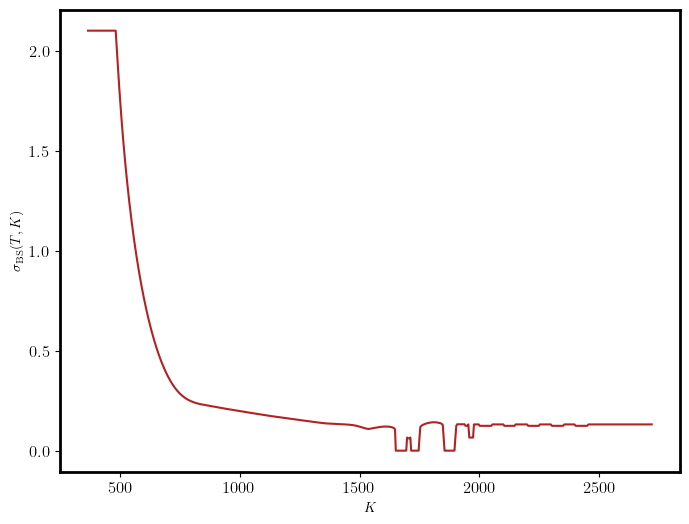

In [100]:
plt.plot(s_0 * np.exp(-grid_x), ivs,  color = 'firebrick')
plt.xlabel(r'$K$')
plt.ylabel(r'$\sigma_{\mathrm{BS}}(T, K)$')

In [109]:
grid.min()

600.0

In [112]:
sigma = lambda x: betas[0] + betas[1] * np.exp(-lambdas[0] * x)  + betas[2] * np.exp(-lambdas[1] * x)


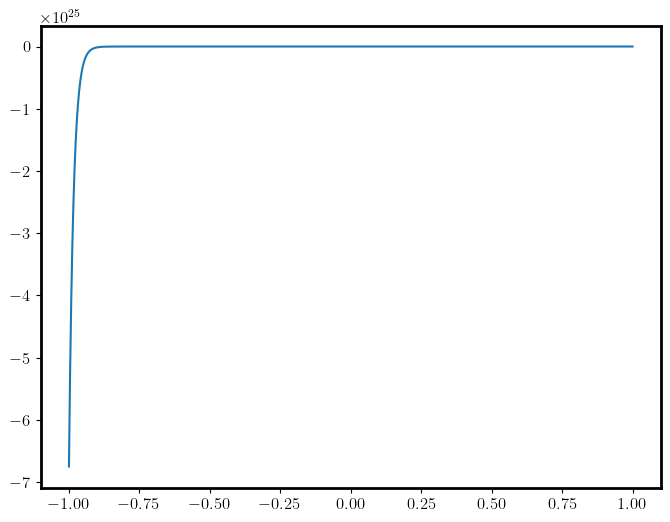

In [115]:
plt.plot(grid_x, sigma(grid_x))